In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import (
    datasets, 
    transforms, 
    models, 
    datasets, 
    utils
)
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

## Utilidades

In [3]:
# (Ligera mejora) Hago que evaluate también devuelva el accuracy para poder usarlo en el bucle
def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Poner el modelo en modo evaluación
    correct = 0
    total = test_loader.dataset.__len__()  # Total de muestras en el conjunto de test
    with torch.no_grad():  # No calcular gradientes
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover datos al dispositivo
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Obtener las predicciones
            correct += (predicted == labels).sum().item()  # Actualizar el contador de aciertos
    accuracy = 100 * correct / total if total > 0 else 0.0
    return accuracy


def train_with_validation(model, train_loader, dev_loader, criterion, optimizer, epochs=5):
    """
    Entrena 'model' durante 'epochs' usando train_loader y evalúa en dev_loader.
    Imprime acc y loss de train y dev por época.
    Devuelve (modelo_entrenado, history) donde history contiene listas por época.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'dev_loss': [],
        'dev_acc': [],
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Limpiar gradientes
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward
            n_classes = outputs.shape[1]
            labels_one_hot = F.one_hot(labels, num_classes=n_classes).float()

            loss = criterion(outputs, labels_one_hot)  # Pérdida
            loss.backward()  # Backward
            optimizer.step()  # Update

            running_loss += loss.item()

            # Accuracy en train
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / max(1, len(train_loader))
        train_acc = 100.0 * correct / max(1, total)

        # ---- Validación (loss) ----
        model.eval()
        dev_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in dev_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                n_classes = outputs.shape[1]
                labels_one_hot = F.one_hot(labels, num_classes=n_classes).float()
                dev_loss = criterion(outputs, labels_one_hot)
                dev_running_loss += dev_loss.item()
        avg_dev_loss = dev_running_loss / max(1, len(dev_loader))

        # ---- Validación (accuracy) usando tu función evaluate ----
        dev_acc = evaluate(model, dev_loader)  # imprime y devuelve accuracy

        # Guardar histórico
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['dev_loss'].append(avg_dev_loss)
        history['dev_acc'].append(dev_acc)

        # Log por época (conciso y claro)
        print(f'[Epoch {epoch + 1}] '
              f'train_loss: {avg_train_loss:.3f} | train_acc: {train_acc:.2f}% | '
              f'dev_loss: {avg_dev_loss:.3f} | dev_acc: {dev_acc:.2f}%')

    return model, history

def plot_training_history(history):
    """
    Dibuja las curvas de loss y accuracy (train y dev) guardadas en el diccionario 'history'.
    Espera claves: 'train_loss', 'train_acc', 'dev_loss', 'dev_acc'.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # --- Loss ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['dev_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # --- Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['dev_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Dataset

Clases del dataset CIFAR-10:
0: avión
1: automóvil
2: pájaro
3: gato
4: ciervo
5: perro
6: rana
7: caballo
8: barco
9: camión

--- Información del dataset ---
Número de imágenes de entrenamiento: 50000
Número de imágenes de prueba: 10000
Tamaño de una imagen: torch.Size([3, 32, 32])

--- Información del batch ---
Dimensión del batch de imágenes: torch.Size([32, 3, 32, 32])
Dimensión del batch de etiquetas: torch.Size([32])


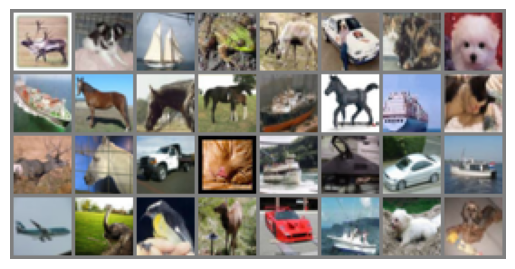

Etiquetas: ciervo | perro | barco | rana | ciervo | automóvil | gato | perro | barco | caballo | caballo | caballo | barco | caballo | barco | gato | ciervo | caballo | camión | gato | barco | avión | automóvil | barco | avión | pájaro | pájaro | ciervo | automóvil | barco | perro | perro


In [5]:
BATCH_SIZE = 32

# --- Transformaciones básicas ---
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalización
])

# --- Descargar dataset CIFAR-10 ---
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# --- Crear dataloaders ---
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# --- Nombres de las clases ---
classes = ('avión', 'automóvil', 'pájaro', 'gato', 'ciervo',
           'perro', 'rana', 'caballo', 'barco', 'camión')

print("Clases del dataset CIFAR-10:")
for i, c in enumerate(classes):
    print(f"{i}: {c}")

# --- Información sobre el dataset ---
print("\n--- Información del dataset ---")
print(f"Número de imágenes de entrenamiento: {len(train_set)}")
print(f"Número de imágenes de prueba: {len(test_set)}")
print(f"Tamaño de una imagen: {train_set[0][0].shape}")  # (3, 32, 32) -> RGB 32x32

# --- Obtener algunas imágenes del loader ---
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("\n--- Información del batch ---")
print(f"Dimensión del batch de imágenes: {images.shape}")  # (batch_size, canales, alto, ancho)
print(f"Dimensión del batch de etiquetas: {labels.shape}")

# --- Función para mostrar imágenes ---
def imshow(img):
    img = img / 2 + 0.5     # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# --- Mostrar imágenes y etiquetas ---
imshow(utils.make_grid(images))
print('Etiquetas:', ' | '.join(f'{classes[labels[j]]}' for j in range(len(labels))))

In [25]:
# --- Configuración Hiperparámetros ---
EPOCHS = 5
LR = 0.001
SEED = 0

In [7]:
def seed_everything(seed):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## Transfer Learning

El *transfer learning* consiste en **aprovechar un modelo preentrenado** en una tarea (normalmente con un dataset grande) como **punto de partida** para una tarea nueva con menos datos o recursos.

## ¿Por qué funciona?
Los modelos profundos aprenden **características jerárquicas**: capas iniciales capturan bordes/texturas (generales) y posteriores capturan patrones más específicos. Reutilizar esas representaciones acelera el entrenamiento y mejora el rendimiento cuando los datos son limitados.

## Estrategias comunes
1. **Feature extractor (congelar el backbone)**  
   - Congelas la red base (`requires_grad=False` o `trainable=False`).  
   - Sustituyes la **capa final** por un clasificador para tus clases.  
   - Pros: rápido, evita sobreajuste con pocos datos.  
   - Contras: menos capacidad de adaptación si el dominio es muy distinto.

2. **Fine-tuning parcial**  
   - Congelas la mayoría de capas y **descongelas las últimas** (más cercanas a la salida).  
   - Buen equilibrio entre *adaptación* y *estabilidad*.

3. **Fine-tuning completo**  
   - Descongelas todo el backbone.  
   - Útil si tu dataset es suficientemente grande o el dominio de tu dataset es identico o muy parecido 
   - Requiere *learning rate* cuidadoso.

## Checklist práctico
- Ajusta la **última capa** al número de clases.  
- Usa *data augmentation* moderado si hay pocos datos.  

## Pequeño ejemplo (PyTorch)
```python
import torchvision.models as models
import torch.nn as nn

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for p in model.parameters():
    p.requires_grad = False  # feature extractor

# Reemplazar clasificador final para N clases
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, N_CLASES)  # cabeza nueva

> Regla de oro: si tu dominio es parecido a ImageNet (o dataset del preentrenamiento), empieza congelando. Si es muy distinto, prueba *fine-tuning* parcial.




In [60]:
model = models.vgg16(weights='IMAGENET1K_V1') # Modelo preentrenado VGG16

In [61]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
seed_everything(SEED)

# Congelar todas las capas del modelo
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.LazyLinear(10)  # CIFAR-10 tiene 10 clases
)

In [63]:
# Mover el modelo al dispositivo disponible (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [64]:
# torchsummary
import torchsummary
torchsummary.summary(model.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
seed_everything(SEED)

model_trained_1, history = train_with_validation(
    model=model,
    train_loader=train_loader,
    dev_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS
)

[Epoch 1] train_loss: 1.338 | train_acc: 55.42% | dev_loss: 1.130 | dev_acc: 61.54%
[Epoch 2] train_loss: 1.219 | train_acc: 59.00% | dev_loss: 1.126 | dev_acc: 62.35%
[Epoch 3] train_loss: 1.182 | train_acc: 60.22% | dev_loss: 1.148 | dev_acc: 61.95%
[Epoch 4] train_loss: 1.156 | train_acc: 60.99% | dev_loss: 1.141 | dev_acc: 63.17%
[Epoch 5] train_loss: 1.136 | train_acc: 61.80% | dev_loss: 1.154 | dev_acc: 62.23%


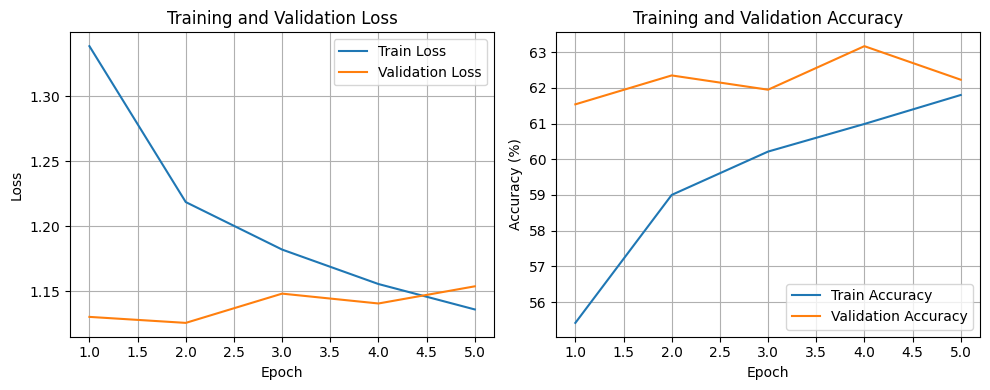

In [66]:
plot_training_history(history)

In [67]:
eval_accuracy = evaluate(model_trained_1, test_loader)
print(f'\nAccuracy final en el conjunto de prueba: {eval_accuracy:.2f}%')


Accuracy final en el conjunto de prueba: 62.23%


## Entrenar todas las capas

In [ ]:
seed_everything(SEED)

model = models.vgg16(weights='IMAGENET1K_V1') # Modelo preentrenado VGG16
model.classifier = nn.Sequential(
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.LazyLinear(10)  # CIFAR-10 tiene 10 clases
)

In [69]:
# torchsummary
import torchsummary
torchsummary.summary(model.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
seed_everything(SEED)

model_trained_2, history = train_with_validation(
    model=model,
    train_loader=train_loader,
    dev_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS
)

[Epoch 1] train_loss: 2.333 | train_acc: 10.10% | dev_loss: 2.325 | dev_acc: 9.65%
[Epoch 2] train_loss: 2.333 | train_acc: 10.13% | dev_loss: 2.325 | dev_acc: 9.65%
[Epoch 3] train_loss: 2.332 | train_acc: 10.10% | dev_loss: 2.325 | dev_acc: 9.65%
[Epoch 4] train_loss: 2.331 | train_acc: 10.21% | dev_loss: 2.325 | dev_acc: 9.65%
[Epoch 5] train_loss: 2.332 | train_acc: 9.84% | dev_loss: 2.325 | dev_acc: 9.65%


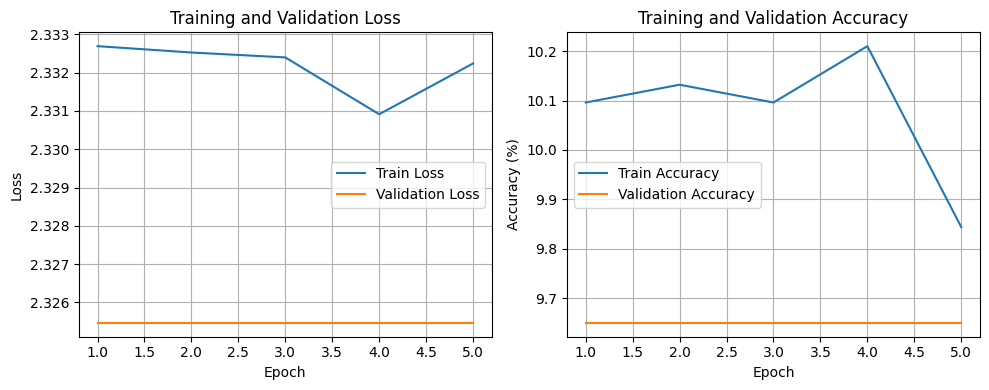

In [71]:
plot_training_history(history)

## Evaluación

In [58]:
!pip install scikit-learn seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 12.7 MB/s  0:00:00 eta 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.3 MB/s  0:00:00 eta 0:00:01
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.7 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━

# Matriz de Confusión y Métricas de Clasificación

La **matriz de confusión** resume el desempeño de un clasificador comparando **etiquetas reales** vs **predichas**.  
Para clasificación binaria (Positivo/Negativo):

- **TP** (verdaderos positivos): predice Positivo y es Positivo.  
- **TN** (verdaderos negativos): predice Negativo y es Negativo.  
- **FP** (falsos positivos): predice Positivo y es Negativo.  
- **FN** (falsos negativos): predice Negativo y es Positivo.

## Métricas derivadas
- **Accuracy** = (TP + TN) / (TP + TN + FP + FN)  
- **Precision** = TP / (TP + FP)  → ¿de lo que predije como Positivo, cuántos lo eran?  
- **Recall** (Sensibilidad) = TP / (TP + FN)  → ¿de los Positivos reales, cuántos detecté?  
- **F1-score** = 2 · (Precision · Recall) / (Precision + Recall)

En problemas **desbalanceados**, la *accuracy* puede ser engañosa; prioriza *precision/recall*.

## En varios clases (multiclase)
La matriz crece a tamaño **C×C** (C = nº de clases). Las métricas pueden **agregarse** como:
- **Macro**: media simple sobre clases (trata todas las clases por igual).  
- **Weighted**: ponderada por soporte (nº de muestras por clase).

## Ejemplo (scikit-learn)
```python
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_true, y_pred, labels=clases)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(xticks_rotation=45)

print(classification_report(y_true, y_pred, target_names=clases))
```

> **Consejo:** inspecciona qué clases se **confunden** más para orientar *data augmentation*, reponderación de pérdidas o recolección de más datos específicos.


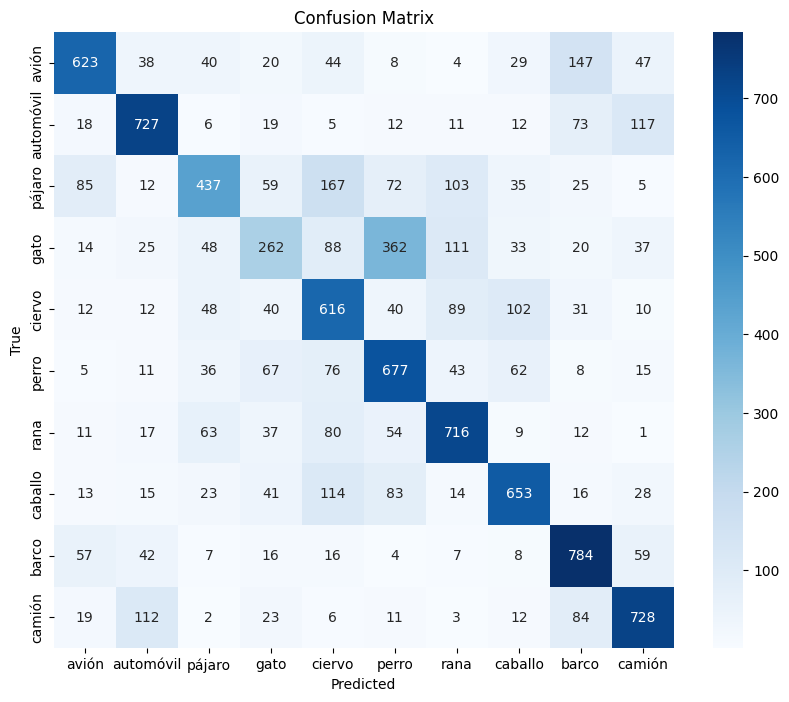

In [72]:
# matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Evaluación
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_trained_1.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_trained_1(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [73]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

       avión       0.73      0.62      0.67      1000
   automóvil       0.72      0.73      0.72      1000
      pájaro       0.62      0.44      0.51      1000
        gato       0.45      0.26      0.33      1000
      ciervo       0.51      0.62      0.56      1000
       perro       0.51      0.68      0.58      1000
        rana       0.65      0.72      0.68      1000
     caballo       0.68      0.65      0.67      1000
       barco       0.65      0.78      0.71      1000
      camión       0.70      0.73      0.71      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.61     10000
weighted avg       0.62      0.62      0.61     10000

